In [1]:
import pandas as pd
import numpy as np
import pdpipe as pdp
from matplotlib import pyplot as plt
%matplotlib inline

import sys
sys.path.append("..")

# Figure S1, 研究区

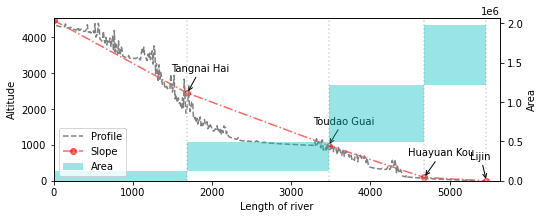

In [2]:
# 处理高程数据

# 处理控制站点数据（来源于黄河流域综合规划）
features = pd.read_csv("../data/hydrology/river_features.csv")
features.columns = [k.strip() for k in features.columns]
length = features['length'].cumsum().values.tolist()
length.insert(0, 0)
fall = features['fall'].sort_index(ascending=False).cumsum().sort_index(ascending=True).values.tolist()
fall.insert(4, 0)

# 处理高程数据 （来源于Arcgis DEM数据）
from tools.processing import dbf_data_list, pd_read_dbf
altitude = pd_read_dbf('../data/hydrology/altitude_points_along_yr/altitude_points.dbf', usecols=['Shape_Leng', 'RASTERVALU'])
altitude['Shape_Leng'] /= 1000  # 单位将 米 转化为 千米
# altitude['RASTERVALU'] /= 1000  # 高程单位转化为千米
# 485号点开始，有几个数据是错误的位置，给他们标好顺序
reindex = list(np.arange(len(altitude) - 485, len(altitude))) + list(np.arange(len(altitude) - 485))
altitude.index = reindex 
altitude.sort_index(inplace=True)
# 将河流全长，按照点的数量进行划分
altitude['Shape_Leng'] = np.linspace(0, altitude['Shape_Leng'].iloc[0], len(altitude))

# 处理流域集水面积数据
stations = pd.read_csv('../data/hydrology/hydro_stations.csv')

# 作图
fig, ax = plt.subplots(figsize=(8, 3))

slope = ax.plot(length, fall, "-.o", color='red', alpha=0.6, label='Slope')
profile = ax.plot(altitude['Shape_Leng'], altitude['RASTERVALU'], '--', color='gray', label='Profile')
for i, x in enumerate(length):
    ax.axvline(x, ls=":", color='lightgray')

# 绘制图 2 每个站点的流域控制面积
ax2 = ax.twinx()
bottom = 0
for i in range(4):
    height = stations['catchment area'][i]
    width = length[i+1]-length[i]
    center = length[i] + width/2
    area = ax2.bar(x=length[i], align='edge', width=width, bottom=bottom, height=height, color='c', alpha=.4, label='Area')
    bottom += height
    ax.annotate(stations['station'][i],
            xy=(length[i+1], fall[i+1]), xycoords='data',
            xytext=(length[i+1]-200, fall[i+1]+600), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle='arc3'))

ax.set_xlim(altitude['Shape_Leng'].min(), altitude['Shape_Leng'].max()*1.06)
ax.set_ylim(altitude['RASTERVALU'].min(), altitude['RASTERVALU'].max())
ax.set_xlabel("Length of river")
ax.set_ylabel("Altitude")
ax2.set_ylabel("Area")
plt.legend(handles=profile + slope + [area], loc='lower left')
# 添加指示线，控制站名称

plt.savefig('../figures/supplementary_information/slope.jpg', dpi=300)
plt.show();

# Figure S2, 子区域的对比

**加载经济数据**

经济数据来源 Wind 数据库，中国各个省份的第一、第二、第三产业 GDP 数据。

In [3]:
# 加载经济数据
gdp = (pd.read_excel('../data/GDP.xlsx')  # 读取数据
        .drop(0)  # 删除单位行
        .astype(float)  # 转为浮点
        .rename({'指标名称': 'Year'}, axis=1)  # 将年份列改名
        .astype({'Year': int})  # 将年份从浮点改为整形
        .set_index('Year')  # 并设置为索引
        .replace(0., np.nan)  # 空值是没数据，不可能为 0
        .drop(list(np.arange(1949, 1965)), axis=0)  # 删除不考虑的时间范围
        )

industries = ['第一', '第二', '第三']  # 三个产业
industries_eng = ['Agriculture', 'Industry', 'Services']  # 三个产业对应的英文
gdp.head()

,北京:GDP:第一产业,北京:GDP:第二产业,北京:GDP:第三产业,天津:GDP:第一产业,天津:GDP:第二产业,天津:GDP:第三产业,河北:GDP:第一产业,河北:GDP:第二产业,河北:GDP:第三产业,山西:GDP:第一产业,...,新疆:GDP:第三产业,兵团:GDP:第一产业,兵团:GDP:第二产业,兵团:GDP:第三产业,珠三角:GDP:第一产业,珠三角:GDP:第二产业,珠三角:GDP:第三产业,长三角:GDP:第一产业,长三角:GDP:第二产业:合计,长三角:GDP:第三产业:合计
Year,,,,,,,,,,,,,,,,,,,,,
1965,4.96,23.50,11.33,3.91,22.96,9.09,37.20,19.99,15.53,12.70,...,4.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966,5.24,28.41,10.76,2.69,26.87,9.75,40.12,22.42,17.70,14.22,...,4.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1967,5.30,22.37,10.19,3.50,20.93,9.19,40.06,21.19,16.86,14.34,...,4.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1968,5.48,22.13,10.21,3.60,21.26,9.91,40.35,23.01,16.07,13.72,...,3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969,4.71,33.60,12.32,3.46,29.03,10.38,44.11,29.47,18.58,15.68,...,3.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**将省份按黄河流域分区归类**

In [4]:
# 清洗列名
def clean_col_names(name):
    elements = col.split(':')  # 分割列名
    province = elements[0].strip()  # 地名
    industry = elements[-1].strip()  # 产业
    return province, industry

from tools.processing import get_region_by_province_name

regions = ['SR', 'UR', 'MR', 'DR']  # 设置区域
region_dict = {region: pd.DataFrame() for region in regions}  # 用来储存每个区域的GDP数据
for col in gdp:
    province, industry = clean_col_names(col)  # 清洗列名
    region = get_region_by_province_name(province)  # 属于哪个区域
    if region: region_dict[region][col] = gdp[col]  # 如果是黄河流域的省份，存进对应的字典
    else:  gdp.drop(col, axis=1, inplace=True)  # 不是黄河流域的省份，就丢掉


**每个区域的一二三产业对比**

In [5]:
# 根据年份，提取数据
def extract_data_by_yr(data, start_yr, end_yr):
    # 当需要提取的年份在起点年份之前，采用时间序列中最早的一年
    if start_yr not in data.index:
        start_yr = data.index[0]
    # 同理，如果终点年份超出索引，采用最晚的一年
    if end_yr not in data.index:
        end_yr = data.index[-1]

    # 当两者相等时，无标准差
    if start_yr == end_yr:
        return data.loc[end_yr], False
    else:
        use_data = data.loc[start_yr: end_yr]
        return np.mean(use_data), np.std(use_data)


def plot_bar_by_category(ax, data, categories, colors, position, start_yr, end_yr, **kargs):
    """ 绘制一个分类柱状图，将不同类别画在同一个位置上
    ax: 绘图区域
    data: 数据，DataFrame，index 是时间（年份），列与 categories 相关
    categories: 分类列表，其中的类应该是 data 中出现的列名
    colors: 每个类使用的颜色
    position: 这个分类柱状图的柱子位置
    start_yr: 截取数据的起始年
    end_yr: 截取数据的末位年
    **kargs: 与绘图相关的参数
    ---------------------------------------------
    return: 返回图例
    """
    bottom = 0  # 初始的柱状图底
    legends = []  # 图例
    for i, category in enumerate(categories):  # 对每个分类
        use_data = data[category]  # 数据是其中的类
        height, std = extract_data_by_yr(use_data, start_yr, end_yr)
        if std:  # 如果有标准差，就绘制误差线
            bar = ax.bar(
                x=position,
                bottom=bottom,
                height=height, 
                yerr=std,
                color=colors[i],
                **kargs
            )
        else:
            bar = ax.bar(
                x=position,
                bottom=bottom,
                height=height, 
                color=colors[i],
                **kargs
            )
        # 每次循环之后：
        bottom += height  # 原先的高作为新的底
        legends.append(bar)  # 图像存为图例
    return legends

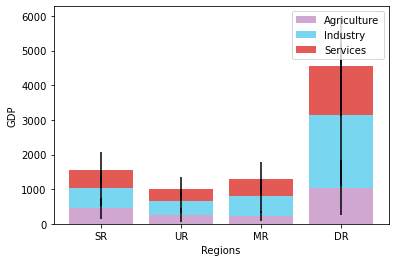

In [6]:
# 根据指定的产业提取数据，计算区域总的 GDP
def extract_gdp_by_industry(data, industry):
    """ 根据指定的产业，提取GDP数据
    data: GDP 数据，列名格式为："地区: GDP: 第X产业"
    industry: 需要提取的产业
    --------------------------------
    return: 给定数据集中，所有该产业的逐年 GDP
    """
    df = pd.DataFrame()
    for col in data:
        if industry in col:
            df[col] = data[col]
        else:
            continue
    return df.sum(axis=1)


# GDP 制图
def plot_gdp(ax, colors, start_yr, end_yr, **kargs):
    
    # 对每个区域进行处理
    for i, region in enumerate(regions):
        use_data = region_dict[region]  # 某个区域的数据
        industries_gdp = []  # 用来储存该区域的 一、二、三 产业的总平均 gdp
        industries_std = []  # 用来储存该区域的 一、二、三 产业的gdp方差

        gdp_region_data = {}
        # 对每个产业进行处理
        for industry in industries:
            # 该区域、该产业的gdp序列，以产业为键存入字典，以供函数调用
            gdp_region_data[industry] = extract_gdp_by_industry(use_data, industry)

        legends = plot_bar_by_category(
            ax=ax,
            data=gdp_region_data,
            categories=industries, 
            position=i,
            start_yr=start_yr,
            end_yr=end_yr,
            colors=colors,
            **kargs
        )
        
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(regions)
    ax.set_xlabel('Regions')
    ax.set_ylabel('GDP')
    ax.legend(legends, labels=industries_eng)
    return industries_gdp

gdp_colors = ['#CFA7D1', '#79D6F0', '#E25A53']  # 使用的颜色参数
start_yr, end_yr = 1980, 2000  # 决定观察的时间范围
fig, ax = plt.subplots()  # 制图
plot_gdp(ax, gdp_colors, start_yr, end_yr, width=0.8)
plt.show();

**各区域的人口对比**

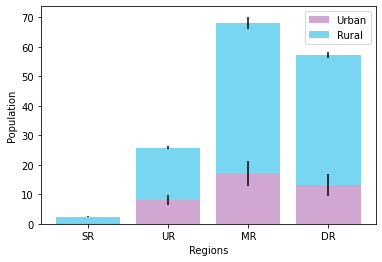

In [7]:
# 加载阈值为 0.05的数据，即与黄河流域相交面积大于全市总面积 5% 的所有市
city_yr = pd.read_csv('../data/perfectures/yr/perfectures_in_YR_with_threshold_0.05.csv')

# 包含人口的列
population = ['Urban population', 'Rural population']
pop = city_yr[['Year', 'Region'] + population]


# 提取每个区域，特定年份的人口数量
def plot_pop(ax, colors, start_yr, end_yr, **kargs):
    for i, region in enumerate(regions):
        use_data = pop.groupby(['Region', 'Year']).sum().loc[region]  # 关注区域的年人口变化
        legends = plot_bar_by_category(
            ax=ax,
            data=use_data,
            categories=population,
            position=i,
            start_yr=start_yr,
            end_yr=end_yr,
            colors=colors,
            **kargs
        )
    ax.legend(labels=['Urban', 'Rural'])
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(regions)
    ax.set_xlabel('Regions')
    ax.set_ylabel('Population')
    
fig, ax = plt.subplots()
plot_pop(ax, colors=gdp_colors, start_yr=start_yr, end_yr=end_yr)
plt.show();

**耗水量对比**

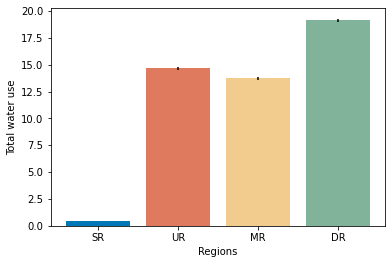

In [8]:
# 包含人口的列
water_use = city_yr[['Year', 'Region', 'Total water use']]

# 提取每个区域，特定年份的人口数量
def plot_wu(ax, colors, start_yr, end_yr, **kargs):
    legends = []
    for i, region in enumerate(regions):
        use_data = water_use.groupby(['Region', 'Year']).sum().loc[region]  # 关注区域的年人口变化
        mean, std = extract_data_by_yr(use_data, start_yr, end_yr)     
        bar = ax.bar(
                x=i,
                height=mean,
                yerr=std,
                color=colors[i],
                **kargs
            )
        legends.append(bar)
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(regions)
    ax.set_xlabel('Regions')
    ax.set_ylabel('Total water use')
    
fig, ax = plt.subplots()
region_colors = ["#0077b6", "#e07a5f", "#f2cc8f","#81b29a"]
plot_wu(ax, colors=region_colors, start_yr=1980, end_yr=1982)
plt.show();

**天然产水量**


In [9]:
# 加载实测径流量
def get_measured_runoff(region):
    use_cols = {
        '年份': 'Year',
        '唐乃亥': 'SR',  # 唐乃亥控制源区
        '头道拐': 'UR',  # 头道拐控制上游
        '花园口': 'MR',  # 花园口控制中游
        '利津': 'DR'     # 利津控制下游
    }
    measured_runoff = pd.read_csv(r'../data/hydrology/1956-2016_runoff.csv')
    measured_runoff = measured_runoff.loc[:, use_cols.keys()]
    measured_runoff.rename(use_cols, axis=1, inplace=True)
    measured_runoff.set_index('Year', inplace=True)
    return measured_runoff[region]


# 获取天然径流量的差值
def get_runoff_difference(region):
    index = regions.index(region)
    if index == 0:
        runoff_in = 0
    else:
        runoff_in = get_measured_runoff(regions[index-1])
    runoff_out = get_measured_runoff(region)
    return runoff_out - runoff_in


# 加载消耗量
def get_consumptions(region):
    """计算从此区域及其上游区域，合计的【水资源】消耗量"""
    consumption = water_use.groupby(['Region', 'Year']).sum().loc[region]['Total water use']
    flag = 0
    index = regions.index(region)
    while flag < index:
        consumption += water_use.groupby(['Region', 'Year']).sum().loc[regions[flag]]['Total water use']
        flag += 1
    return consumption * 10  # 单位由 10^8 变成 10^9


# 计算每个区域的地表/地下水修正系数
def get_surface_groundwater_coefficient(region):
    watersheds = pd.read_csv(r"../data/watershed_merged.csv")

    def get_type_data(d, p):
        return d.groupby("项目").get_group(p)

    SR = ['龙羊峡以上', '龙羊峡至兰州', '河源-兰州']
    UR = ['兰州至头道拐', '兰州-头道拐']
    MR = ['头道拐至龙门', '龙门至三门峡', '三门峡至花园口', '头道拐-龙门', '龙门-三门峡', '三门峡-花园口']
    DR = ['花园口以下', '花园口-利津', '利津-河口']
    WATERSHED_TO_SUBREGION = {
        "SR": SR,
        "UR": UR,
        "MR": MR,
        "DR": DR
    }

    def judge_region(x):
        for k, v in WATERSHED_TO_SUBREGION.items():
            if x in v:
                return k

            
    watersheds['region'] = watersheds['分区'].apply(judge_region)
    watersheds = watersheds[watersheds['region'].notna()]
    withdraw = get_type_data(watersheds, "取水量")

    def calculate_ratio(data, sector):
        sur = sector + "_surface"
        gro = sector + "_groundwater"
        data[sector+'_sum'] = data[sur] + data[gro]
        data[sector+'_ratio'] = data[gro] / data[sector+'_sum']
        return data

    data = calculate_ratio(withdraw, '合计').groupby(['region', '年份']).mean()['合计_ratio']
    return data.loc[region]

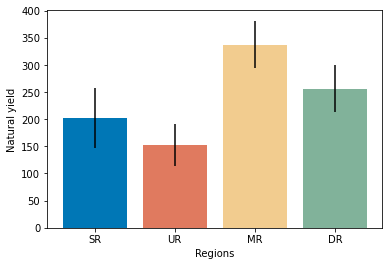

In [10]:
def plot_water(ax, start_yr, end_yr, colors):
    legends = []  # 图例
    for i, region in enumerate(regions):  # 循环每个区域
        measured_runoff = get_runoff_difference(region)  # 获取这个区域的径流量
        wu = get_consumptions(region)  # 获取该区域的消耗量
        c_ser = get_surface_groundwater_coefficient(region)
        c = extract_data_by_yr(c_ser, start_yr, end_yr)[0]
        natual_runoff = measured_runoff + wu * (1-c)
        mean, std = extract_data_by_yr(natual_runoff, start_yr, end_yr)
        bar = ax.bar(
            x=i,
            height=mean,
            yerr=std,
            color=colors[i]
        )
        legends.append(bar)
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(regions)
    ax.set_xlabel('Regions')
    ax.set_ylabel('Natural yield')

fig, ax = plt.subplots()
plot_water(ax, 1980, 2010, colors=region_colors)

## 区域差异合并作图

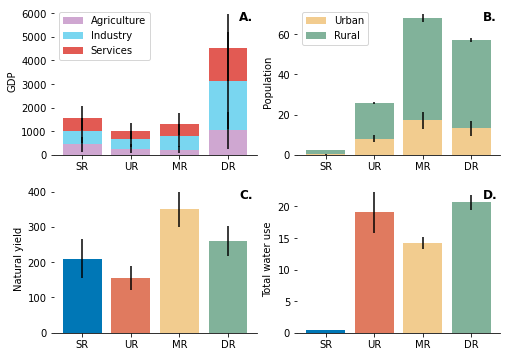

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

start_yr, end_yr = 1980, 2000
plot_gdp(ax1, gdp_colors, start_yr, end_yr)
plot_pop(ax2, region_colors[-2:], start_yr, end_yr)
plot_water(ax3, start_yr, end_yr, region_colors)
plot_wu(ax4, region_colors, start_yr, end_yr)

# 修饰图片
from tools.processing import get_position_by_ratio

labels = ["A.", "B.", "C.", "D."]
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    x, y =get_position_by_ratio(ax, 0.95, 0.93)
    ax.text(x, y, labels[i], ha='center', va='center', weight='bold', size='large')

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

    ax.set_xlabel("")

plt.savefig("../figures/supplementary_information/region_differences.jpg", dpi=300)
plt.savefig("../figures/supplementary_information/region_differences.pdf", dpi=300)
plt.show();

# Fig. SX 不同时期 GDP 贡献百分比

In [12]:
gdp_yr = pd.DataFrame()
for i, industry in enumerate(industries):
    gdp_yr[industries_eng[i]] = extract_gdp_by_industry(gdp, industry)

gdp_yr.head()

,Agriculture,Industry,Services
Year,,,
1965,170.65,124.34,73.41
1966,183.56,151.27,77.68
1967,189.50,136.87,77.31
1968,181.57,123.24,74.36
1969,194.46,155.47,80.74


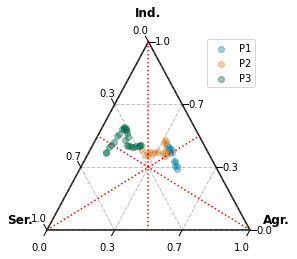

In [13]:
# 制作三元图
period_colors = ['#0889A6', '#F1801F', '#006C43']
points = []
points_1, points_2, points_3 = [], [], []
size_1, size_2, size_3 = [], [], []
scale = 100

z_ipwu, z_wdi, z_sfv = [gdp_yr[col] for col in gdp_yr]
for yr in gdp_yr.index:
    sumed = z_ipwu[yr] + z_wdi[yr] + z_sfv[yr]  # 这里点的大小是三者 z_score 相加
    point = (z_ipwu[yr]/sumed, z_wdi[yr]/sumed, z_sfv[yr]/sumed)
    points.append(point)
    if yr < 1978:
        points_1.append(point)
        size_1.append(sumed * scale)
    elif yr < 1993:
        points_2.append(point)
        size_2.append(sumed * scale)
    else:
        points_3.append(point)
        size_3.append(sumed * scale)

import ternary
fig, ax = plt.subplots(figsize=(4, 4))
figure, tax = ternary.figure(ax=ax, scale=1)
tax.boundary()
tax.gridlines(ls="-.", multiple=1./3, color="gray")
# Plot a few different styles with a legend
tax.scatter(points_1, marker='o', color=period_colors[0], label="P1", alpha=.4)
tax.scatter(points_2, marker='o', color=period_colors[1], label="P2", alpha=.4)
tax.scatter(points_3, marker='o', color=period_colors[2], label="P3", alpha=.4)
tax.plot(points, ls=':', lw='0.7')
fontsize = 12
offset = 0.15

tax.ticks(axis='brl', multiple=1./3, linewidth=1, tick_formats="%.1f", offset=0.03)
# tax.ticks(axis='l', clockwise=True, multiple=1./3, linewidth=1, tick_formats="%.1f", offset=0.03)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()

def get_point(yr):
    a = z_ipwu[yr] + z_wdi[yr] - z_sfv[yr]
    return (z_ipwu[yr]/a, z_wdi[yr]/a, z_sfv[yr]/a)

tax.set_axis_limits((0,1))
# tax.annotate("1965", position=get_point(1965))
# tax.annotate("1978", position=get_point(1978))
# tax.annotate("1994", position=get_point(1994))
# tax.annotate("2013", position=get_point(2013))
tax.line((0,0,1),(.5,.5,0), ls=":", color='red')
tax.line((0,1,0),(.5,0,.5), ls=":", color='red')
tax.line((1,0,0),(0,.5,.5), ls=":", color='red')
tax.right_corner_label("Agr.", fontsize=fontsize, offset=0.3, weight='bold')
tax.top_corner_label("Ind.", fontsize=fontsize, offset=0.25, weight='bold')
tax.left_corner_label("Ser.", fontsize=fontsize, offset=0.3, weight='bold')

tax.legend()
tax.show()
tax.savefig("../figures/supplementary_information/ternary.jpg", dpi=300)
tax.savefig("../figures/supplementary_information/ternary.pdf", dpi=300);